In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/ac209a_project/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/ac209a_project')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
%matplotlib inline 

## Load in trial data and convert into feature dataframe

In [2]:
'''
load in trial data
'''
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked','Right Reward Prob','Left Reward Prob','Reward Given']
df_90 = pd.read_csv('/Users/shayneufeld/GitHub/ac209a_project/data/trials_90_10.csv',names=columns)
df_70 = pd.read_csv('/Users/shayneufeld/GitHub/ac209a_project/data/trials_70_30.csv',names=columns)

In [3]:
df_90.loc[df_90['Port Poked'] == 1,'Port Poked'] = 'Right'
df_90.loc[df_90['Port Poked'] == 2,'Port Poked'] = 'Left'

In [4]:
'''
convert into feature dataframe
'''
feature_names = ['Previous_10_Left_Choice',
                 'Previous_10_Right_Choice',
                 'Previous_10_Left_Reward',
                 'Previous_10_Right_Reward',
                 'Streak',
                 '5_Port',
                 '5_Reward',
                 '5_ITI',
                 '5_trialDuration',
                 '4_Port',
                 '4_Reward',
                 '4_ITI',
                 '4_trialDuration',
                 '3_Port',
                 '3_Reward',
                 '3_ITI',
                 '3_trialDuration',
                 '2_Port',
                 '2_Reward',
                 '2_ITI',
                 '2_trialDuration',
                 '1_Port',
                 '1_Reward',
                 '1_ITI',
                 '1_trialDuration',
                 '0_ITI',
                 '0_trialDuration',
                 'Decision'
                 ]

In [5]:
df = bp.create_feature_matrix(df_90,10,5,feature_names)

In [6]:
df.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,1.0,9.0,0.0,9.0,1.0,0.0,1.0,2.380,0.573,0.0,...,0.0,3.898,0.582,0.0,1.0,10.666,0.688,1.650,0.428,1.0
1,2.0,8.0,0.0,8.0,-1.0,0.0,1.0,2.240,0.274,0.0,...,1.0,10.666,0.688,1.0,0.0,1.650,0.428,1.421,0.481,0.0
2,2.0,8.0,0.0,8.0,1.0,0.0,1.0,2.083,0.315,1.0,...,0.0,1.650,0.428,0.0,1.0,1.421,0.481,2.850,0.373,0.0
3,2.0,8.0,0.0,8.0,2.0,1.0,0.0,3.898,0.582,0.0,...,1.0,1.421,0.481,0.0,1.0,2.850,0.373,3.563,0.394,0.0
4,2.0,8.0,0.0,8.0,3.0,0.0,1.0,10.666,0.688,1.0,...,1.0,2.850,0.373,0.0,1.0,3.563,0.394,2.821,0.390,0.0


In [22]:
#extract features and decisions
x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [23]:
y_diff = np.diff(y)
x = x[:-1,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(474, 27)
(474,)


In [24]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [25]:
print('# train trials: %.0f | # switches: %.0f' % (x_train.shape[0],np.sum(y_train)))
print('# test trials: %.0f | # switches: %.0f' % (x_test.shape[0],np.sum(y_test)))

# train trials: 331 | # switches: 12
# test trials: 143 | # switches: 4


In [26]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
acc,F1=sf.score_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO          136.0            3.0
True YES           4.0            0.0

F1: 0.000

Score: 0.95


## Much harder for the model! It didn't correct *any* correctly!

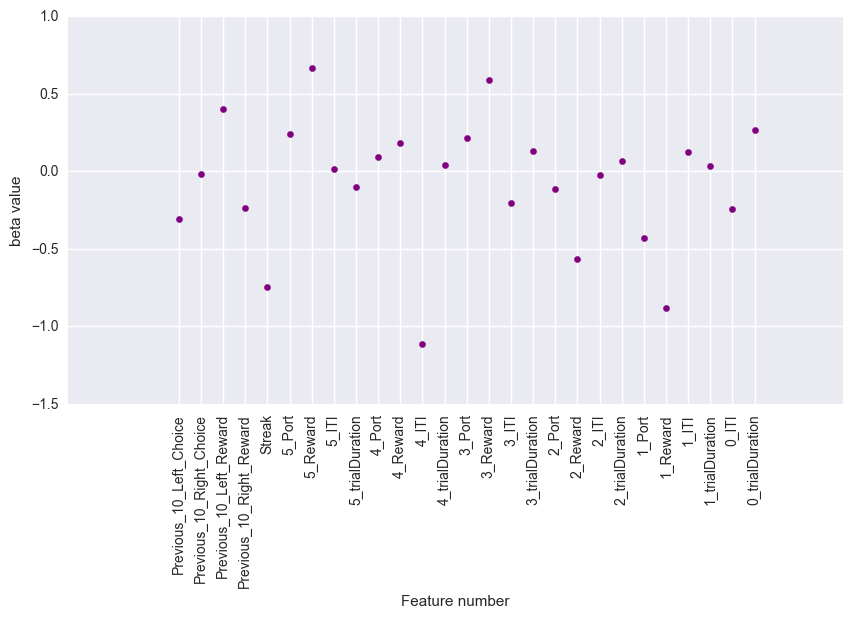

In [27]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

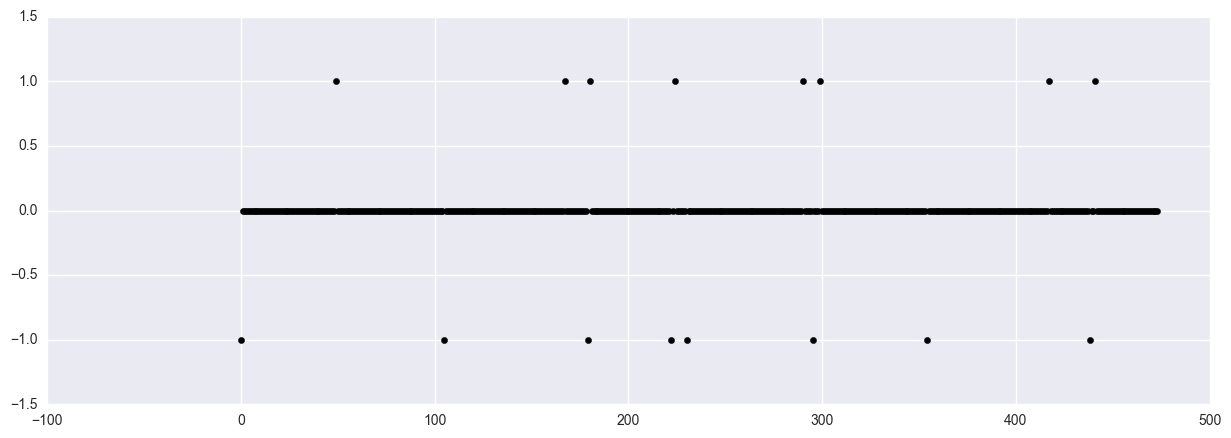

In [28]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(n_trials),y_diff,color='black')

# NOTE: all code below copied from Modeling_attempt0

### It might come in useful as we try and improve the switching predictor model

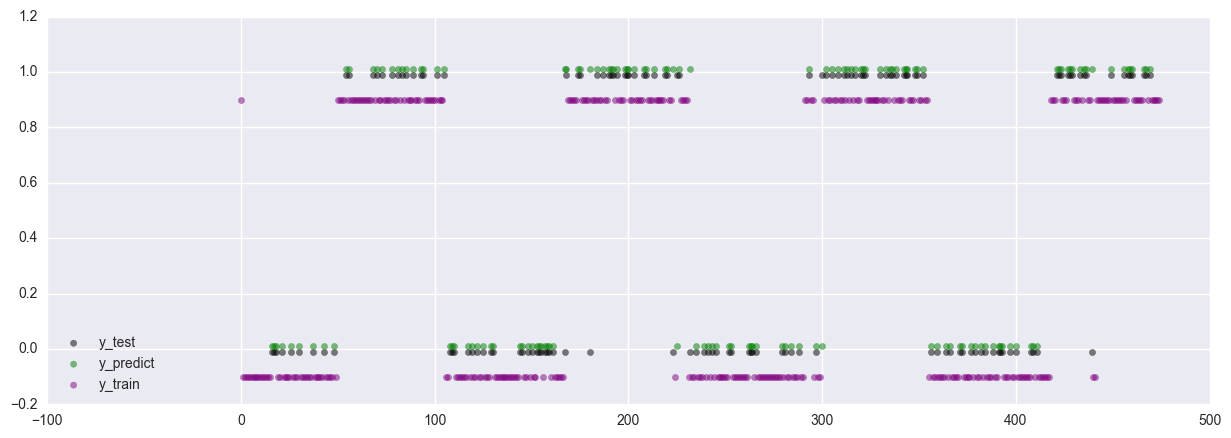

In [70]:
plt.figure(figsize=(15,5))
plt.scatter(shuf_inds[split_ind:],y_test-0.01,color='black',label='y_test',alpha=0.5)
plt.scatter(shuf_inds[split_ind:],y_predict+0.01,color='green',label='y_predict',alpha=0.5)
plt.scatter(shuf_inds[:split_ind],y_train-0.1,color='purple',label='y_train',alpha=0.5)
plt.legend(loc='lower left')

## Try taking out previous port decision

In [78]:
df_mod = df.drop('1_Port',axis=1)
df_mod.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Port,2_Reward,2_ITI,2_trialDuration,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,1.0,9.0,0.0,9.0,1.0,0.0,1.0,2.380,0.573,0.0,...,1.0,0.0,3.898,0.582,1.0,10.666,0.688,1.650,0.428,1.0
1,2.0,8.0,0.0,8.0,-1.0,0.0,1.0,2.240,0.274,0.0,...,0.0,1.0,10.666,0.688,0.0,1.650,0.428,1.421,0.481,0.0
2,2.0,8.0,0.0,8.0,1.0,0.0,1.0,2.083,0.315,1.0,...,1.0,0.0,1.650,0.428,1.0,1.421,0.481,2.850,0.373,0.0
3,2.0,8.0,0.0,8.0,2.0,1.0,0.0,3.898,0.582,0.0,...,0.0,1.0,1.421,0.481,1.0,2.850,0.373,3.563,0.394,0.0
4,2.0,8.0,0.0,8.0,3.0,0.0,1.0,10.666,0.688,1.0,...,0.0,1.0,2.850,0.373,1.0,3.563,0.394,2.821,0.390,0.0


In [126]:
#extract features and decisions
x = df.iloc[:,5:-1].values
y = df.iloc[:,-1].values

In [127]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [115]:
x_train.shape

(332,)

In [128]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
score = logreg.score(x_test,y_test)
score

0.94405594405594406

In [84]:
coefs.shape

(1, 26)

In [89]:
df_mod.columns.values

array(['Previous_10_Left_Choice', 'Previous_10_Right_Choice',
       'Previous_10_Left_Reward', 'Previous_10_Right_Reward', 'Streak',
       '5_Port', '5_Reward', '5_ITI', '5_trialDuration', '4_Port',
       '4_Reward', '4_ITI', '4_trialDuration', '3_Port', '3_Reward',
       '3_ITI', '3_trialDuration', '2_Port', '2_Reward', '2_ITI',
       '2_trialDuration', '1_Reward', '1_ITI', '1_trialDuration', '0_ITI',
       '0_trialDuration', 'Decision'], dtype=object)

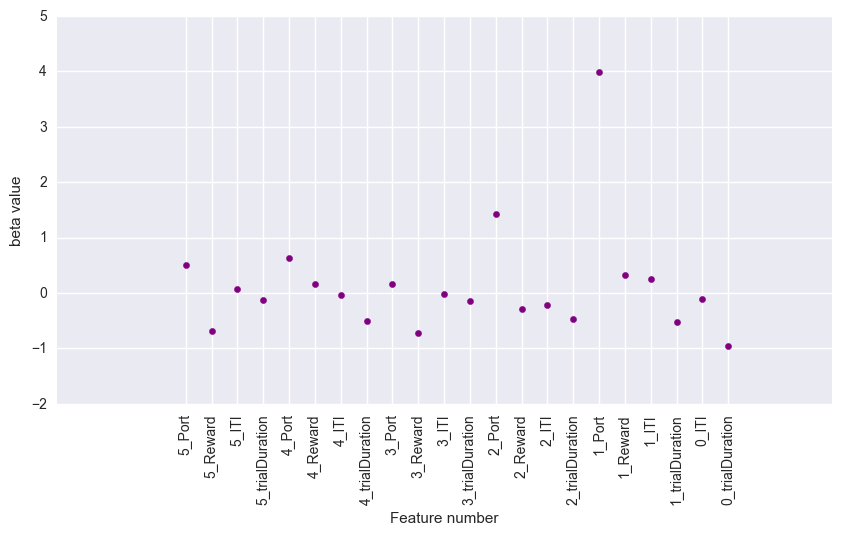

In [130]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),df.iloc[:,5:-1].columns.values,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

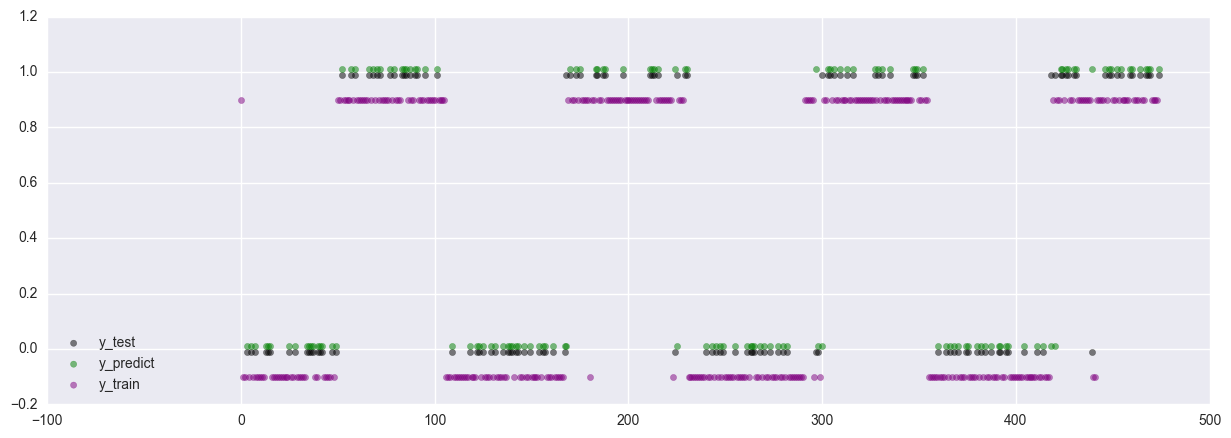

In [131]:
plt.figure(figsize=(15,5))
plt.scatter(shuf_inds[split_ind:],y_test-0.01,color='black',label='y_test',alpha=0.5)
plt.scatter(shuf_inds[split_ind:],y_predict+0.01,color='green',label='y_predict',alpha=0.5)
plt.scatter(shuf_inds[:split_ind],y_train-0.1,color='purple',label='y_train',alpha=0.5)
plt.legend(loc='lower left')

# Try only using inter-trial-intervals

In [145]:
df_events = df[['5_trialDuration','4_trialDuration','3_trialDuration','2_trialDuration','1_trialDuration','Decision']]
df_events.head(5)

,5_trialDuration,4_trialDuration,3_trialDuration,2_trialDuration,1_trialDuration,Decision
0,0.573,0.274,0.315,0.582,0.688,1.0
1,0.274,0.315,0.582,0.688,0.428,0.0
2,0.315,0.582,0.688,0.428,0.481,0.0
3,0.582,0.688,0.428,0.481,0.373,0.0
4,0.688,0.428,0.481,0.373,0.394,0.0


In [146]:
#extract features and decisions
x = df_events.iloc[:,:-1].values
y = df_events.iloc[:,-1].values

In [151]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [152]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
score = logreg.score(x_test,y_test)
score

0.52447552447552448

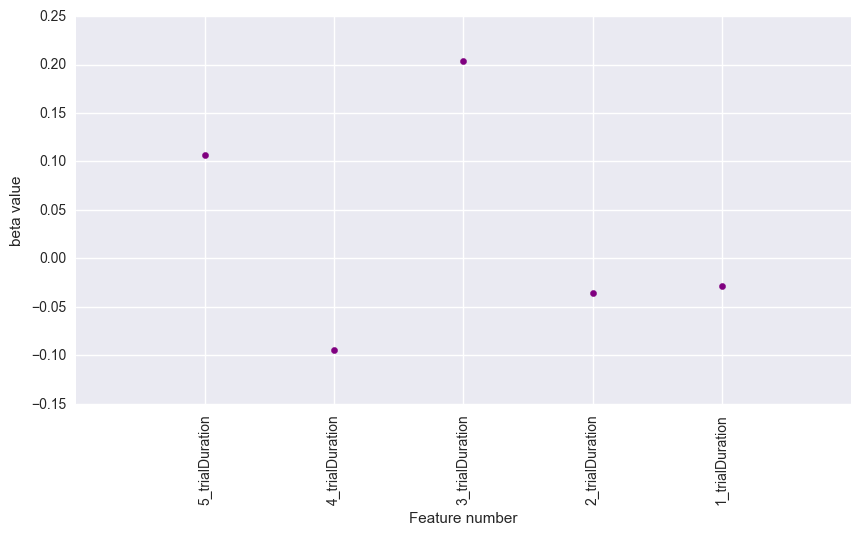

In [153]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),df_events.iloc[:,:-1].columns.values,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

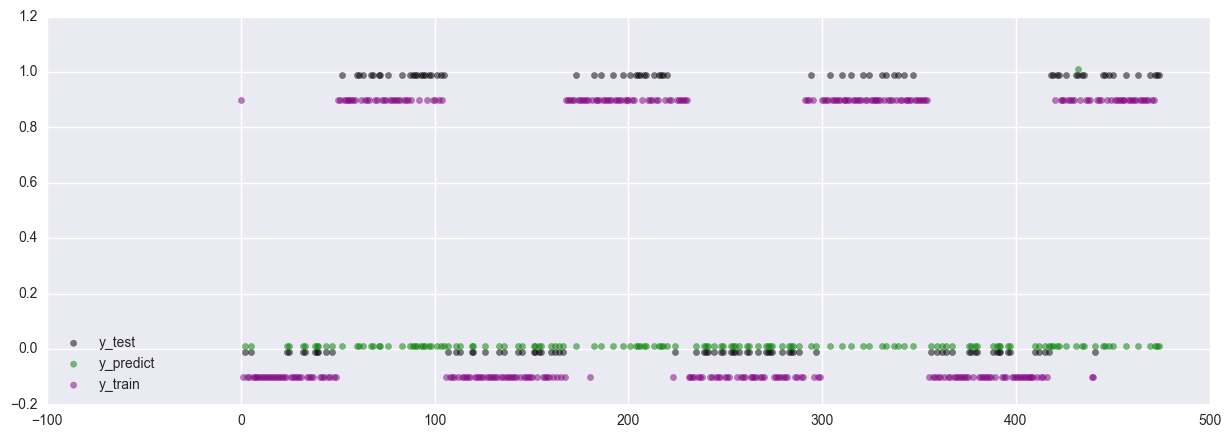

In [154]:
plt.figure(figsize=(15,5))
plt.scatter(shuf_inds[split_ind:],y_test-0.01,color='black',label='y_test',alpha=0.5)
plt.scatter(shuf_inds[split_ind:],y_predict+0.01,color='green',label='y_predict',alpha=0.5)
plt.scatter(shuf_inds[:split_ind],y_train-0.1,color='purple',label='y_train',alpha=0.5)
plt.legend(loc='lower left')

Quick notes since we did this all a little hastily:

    1) summary data good enough to get ~95% accuracy which was comparable to using all features
    2) streak, ITI, trialDuration by themselves did not perform better than chance
    3) taking out trial -1 Port did not affect model even though it had highest beta coefficient
    4) only using past 5 trials good enough for 95% accuracy with trial -1,-2 port decisions the highest betas